In [1]:
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras

## Generate 2D synthetic data

In [2]:
# 2D random data
x, y = make_classification(n_samples=1000,
                          n_features=2,
                          n_informative=1,
                          n_redundant=0,
                          n_clusters_per_class=1,
                          random_state=2020)

# normalize
x_norm = (x - x.min(axis=0)) / x.ptp(axis=0)

## Plot data

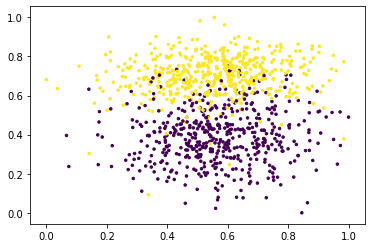

In [3]:
plt.figure()
plt.scatter(x_norm[:, 0], x_norm[:, 1], marker='.', c=y, s=25, edgecolor='face')
plt.grid(False)
plt.show()

## Split train and test data

In [4]:
train_indices = np.random.choice(len(x_norm), round(len(x_norm)*0.8), replace=False)
test_indices = np.array(list(set(range(len(x))) - set(train_indices)))

# one hot encoding
y_one = np.eye(len(set(y)))[y]

# x_train = tf.Variable(x_norm[train_indices], dtype=tf.float32)
# x_test = tf.Variable(x_norm[test_indices], dtype=tf.float32)
# y_train = tf.Variable(y_one[train_indices], dtype=tf.int32)
# y_test = tf.Variable(y_one[test_indices], dtype=tf.int32)

x_train = x_norm[train_indices]
x_test = x_norm[test_indices]
y_train = y_one[train_indices]
y_test = y_one[test_indices]

In [5]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(x_train[1])
print(y_train[1])

(800, 2)
(800, 2)
(200, 2)
(200, 2)
[0.56714115 0.44766936]
[1. 0.]


## kNN 

In [6]:
k = 9

# prediction
d0 = tf.expand_dims(x_test, axis=1)
print(d0.shape)
d1 = tf.subtract(x_train, d0)
print(d1.shape)
distance = tf.reduce_sum(tf.abs(d1), axis=2)

_, top_k_indices = tf.nn.top_k(tf.negative(distance), k=k)
top_k_labels = tf.gather(y_train, top_k_indices)

sum_predictions = tf.reduce_sum(top_k_labels, axis=1)
predictions = tf.argmax(sum_predictions, axis=1, output_type=tf.int32)

(200, 1, 2)
(200, 800, 2)


## Computing the accuracy

In [7]:
# get labels from test set
actual = tf.Variable(y[test_indices], dtype=tf.int32)

correct_count = tf.reduce_sum(tf.dtypes.cast(tf.math.equal(predictions, actual), tf.int32))
accuracy = correct_count / y_test.shape[0] * 100
print("Accuracy = ",accuracy.numpy(),"%")

Accuracy =  91.5 %


## Linear model

In [8]:
model = keras.Sequential([
    keras.layers.Dense(2, activation='softmax', input_shape=[2])
])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2)                 6         
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [11]:
model.fit(x_train, y_train, epochs=200, verbose=1)

Train on 800 samples
Epoch 1/200
800/800 [==============================] - 1s 897us/sample - loss: 0.6541 - accuracy: 0.5100
Epoch 2/200
800/800 [==============================] - 0s 88us/sample - loss: 0.6431 - accuracy: 0.5138
Epoch 3/200
800/800 [==============================] - 0s 93us/sample - loss: 0.6340 - accuracy: 0.5200
Epoch 4/200
800/800 [==============================] - 0s 99us/sample - loss: 0.6262 - accuracy: 0.5288
Epoch 5/200
800/800 [==============================] - 0s 208us/sample - loss: 0.6202 - accuracy: 0.5450
Epoch 6/200
800/800 [==============================] - 0s 77us/sample - loss: 0.6151 - accuracy: 0.5650
Epoch 7/200
800/800 [==============================] - 0s 112us/sample - loss: 0.6105 - accuracy: 0.5900
Epoch 8/200
800/800 [==============================] - 0s 84us/sample - loss: 0.6065 - accuracy: 0.6175
Epoch 9/200
800/800 [==============================] - 0s 89us/sample - loss: 0.6028 - accuracy: 0.6375
Epoch 10/200
800/800 [==================

800/800 [==============================] - 0s 56us/sample - loss: 0.4632 - accuracy: 0.8988
Epoch 79/200
800/800 [==============================] - 0s 64us/sample - loss: 0.4617 - accuracy: 0.8963
Epoch 80/200
800/800 [==============================] - 0s 52us/sample - loss: 0.4605 - accuracy: 0.8963
Epoch 81/200
800/800 [==============================] - 0s 56us/sample - loss: 0.4590 - accuracy: 0.8963
Epoch 82/200
800/800 [==============================] - 0s 55us/sample - loss: 0.4577 - accuracy: 0.8963
Epoch 83/200
800/800 [==============================] - 0s 52us/sample - loss: 0.4564 - accuracy: 0.8963
Epoch 84/200
800/800 [==============================] - 0s 54us/sample - loss: 0.4551 - accuracy: 0.8988
Epoch 85/200
800/800 [==============================] - 0s 58us/sample - loss: 0.4537 - accuracy: 0.8988
Epoch 86/200
800/800 [==============================] - 0s 52us/sample - loss: 0.4526 - accuracy: 0.8975
Epoch 87/200
800/800 [==============================] - 0s 55us/samp

800/800 [==============================] - 0s 62us/sample - loss: 0.3834 - accuracy: 0.9062
Epoch 156/200
800/800 [==============================] - 0s 65us/sample - loss: 0.3826 - accuracy: 0.9050
Epoch 157/200
800/800 [==============================] - 0s 51us/sample - loss: 0.3818 - accuracy: 0.9062
Epoch 158/200
800/800 [==============================] - 0s 53us/sample - loss: 0.3810 - accuracy: 0.9050
Epoch 159/200
800/800 [==============================] - 0s 52us/sample - loss: 0.3804 - accuracy: 0.9062
Epoch 160/200
800/800 [==============================] - 0s 52us/sample - loss: 0.3797 - accuracy: 0.9050
Epoch 161/200
800/800 [==============================] - 0s 54us/sample - loss: 0.3789 - accuracy: 0.9062
Epoch 162/200
800/800 [==============================] - 0s 57us/sample - loss: 0.3783 - accuracy: 0.9050
Epoch 163/200
800/800 [==============================] - 0s 53us/sample - loss: 0.3774 - accuracy: 0.9062
Epoch 164/200
800/800 [==============================] - 0s 

In [12]:
model.evaluate(x_test, y_test, verbose=2)

200/1 - 0s - loss: 0.3776 - accuracy: 0.9000


[0.3434950375556946, 0.9]

## Adversarial Examples

In [13]:
print(x_test[:1])
print(y_test[0])

[[0.34758589 0.81666868]]
[0. 1.]


In [14]:
prediction = model.predict(x_test[:1])
prediction[0]

array([0.08834155, 0.91165847], dtype=float32)

In [15]:
loss_func = keras.losses.BinaryCrossentropy()

def create_adversarial_perturbation(input_clean, input_label):
    input_tensor = tf.constant(input_clean, dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(input_tensor)
        pred = model(input_tensor)
        loss = loss_func(input_label, pred)
        
    gradient = tape.gradient(loss, input_tensor)
    return tf.sign(gradient)

### Creating single adversarial example

In [16]:
perturbation = create_adversarial_perturbation(x_test[:1], y_test[0])
perturbation

<tf.Tensor: id=16436, shape=(1, 2), dtype=float32, numpy=array([[ 1., -1.]], dtype=float32)>

In [17]:
epsilon = 0.15
x_ad =  x_test[:1] + epsilon * perturbation
print(x_test[:1])
print(x_ad.numpy())

[[0.34758589 0.81666868]]
[[0.4975859  0.66666865]]


In [18]:
pred_ad = model.predict(x_ad)
pred_ad

array([[0.26563555, 0.7343645 ]], dtype=float32)

### Adversarial examples from full test set

In [19]:
perturbations = create_adversarial_perturbation(x_test, y_test)
print(perturbations[:10])

tf.Tensor(
[[ 1. -1.]
 [-1.  1.]
 [ 1. -1.]
 [-1.  1.]
 [-1.  1.]
 [-1.  1.]
 [-1.  1.]
 [-1.  1.]
 [-1.  1.]
 [-1.  1.]], shape=(10, 2), dtype=float32)


In [20]:
x_ad = x_test + epsilon * perturbations
print(x_test[:10])
print(x_ad[:10])

[[0.34758589 0.81666868]
 [0.61697648 0.22291131]
 [0.17783216 0.63824015]
 [0.30887721 0.21469168]
 [0.59890353 0.34005124]
 [0.76502628 0.18233395]
 [0.52620523 0.42131816]
 [0.61067496 0.28054673]
 [0.48366473 0.55950296]
 [0.56859198 0.07916872]]
tf.Tensor(
[[0.4975859  0.66666865]
 [0.4669765  0.37291133]
 [0.32783216 0.48824015]
 [0.1588772  0.36469167]
 [0.44890353 0.49005124]
 [0.61502624 0.33233395]
 [0.37620524 0.57131815]
 [0.46067497 0.43054673]
 [0.33366472 0.70950294]
 [0.41859195 0.22916873]], shape=(10, 2), dtype=float32)


In [21]:
model.evaluate(x_ad, y_test, verbose=2)

200/1 - 0s - loss: 0.8993 - accuracy: 0.4550


[0.8621531152725219, 0.455]

### Show graph

In [22]:
test_positive_indices = [idx for idx, val in enumerate(y_test) if val[0] == 1]
print(len(test_positive_indices))

103


In [23]:
x_test[list(test_positive_indices)]

array([[0.61697648, 0.22291131],
       [0.30887721, 0.21469168],
       [0.59890353, 0.34005124],
       [0.76502628, 0.18233395],
       [0.52620523, 0.42131816],
       [0.61067496, 0.28054673],
       [0.48366473, 0.55950296],
       [0.56859198, 0.07916872],
       [0.6670072 , 0.43368903],
       [0.72770267, 0.07710096],
       [0.51596778, 0.34059903],
       [0.54887172, 0.4276768 ],
       [0.85747308, 0.31828767],
       [0.68231517, 0.35560371],
       [0.4107325 , 0.40948977],
       [0.52390736, 0.59641836],
       [0.64834224, 0.21931247],
       [0.52245899, 0.25455427],
       [0.68687807, 0.33451481],
       [0.54908929, 0.42861884],
       [0.59336823, 0.48914455],
       [0.28437728, 0.24305329],
       [0.69534968, 0.33083854],
       [0.48353727, 0.38425615],
       [0.78957153, 0.64181779],
       [0.46402762, 0.48829422],
       [0.75437146, 0.43851623],
       [0.73515547, 0.32753175],
       [0.74638246, 0.56949099],
       [0.53949165, 0.44248788],
       [0.

In [24]:
print(len(x_ad))
ad_pred = model.predict(x_ad)
ad_result = tf.math.argmax(ad_pred, axis=1)
print(ad_result.numpy())

200
[1 0 1 0 0 0 1 0 1 0 0 1 1 0 0 1 0 0 0 1 0 1 1 0 0 0 0 1 0 1 1 1 0 1 0 0 1
 1 0 1 0 0 0 1 1 1 0 0 1 1 1 0 0 1 1 1 1 0 1 1 0 1 0 1 1 1 0 1 1 0 0 0 0 0
 1 1 1 1 0 0 0 1 0 0 0 1 1 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 1 1 1 0 0 0
 0 1 1 0 1 0 0 1 1 0 0 0 0 0 0 1 1 0 1 1 1 0 0 1 0 1 0 1 1 1 0 1 0 1 0 0 0
 1 0 1 1 1 0 0 0 1 1 0 1 1 1 1 1 0 0 0 0 1 0 0 0 1 1 0 0 1 1 0 1 1 0 1 1 0
 0 1 0 1 1 0 0 0 0 1 1 0 0 0 0]


In [25]:
len(ad_result.numpy()[list(test_positive_indices)])

103

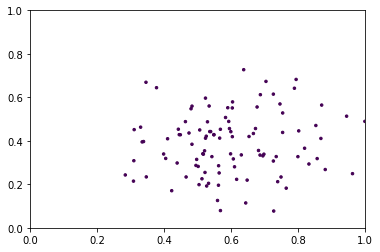

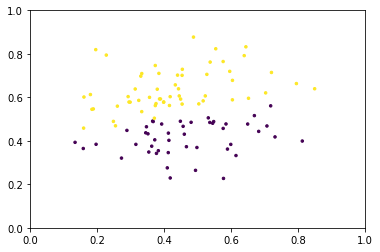

In [26]:
plt.figure()
plt.scatter(x_test[list(test_positive_indices)][:, 0], 
            x_test[list(test_positive_indices)][:, 1], 
            marker='.', 
            c=y[test_indices][list(test_positive_indices)], 
            s=25, 
            edgecolor='face')
plt.grid(False)
plt.ylim(0, 1.0)
plt.xlim(0, 1.0)
plt.show()

plt.figure()
plt.scatter(x_ad.numpy()[list(test_positive_indices)][:, 0], 
            x_ad.numpy()[list(test_positive_indices)][:, 1], 
            marker='.', 
            c=ad_result.numpy()[list(test_positive_indices)], 
            s=25, 
            edgecolor='face')
plt.grid(False)
plt.ylim(0, 1.0)
plt.xlim(0, 1.0)
plt.show()
